### Question 1

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Activation
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

# loading and preprocessing FashionMNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape((-1, 28, 28, 1)).astype("float32") / 255.
x_test = x_test.reshape((-1, 28, 28, 1)).astype("float32") / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# define LeNet5
def build_lenet5():
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), padding='same', input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(5, 5), padding='valid'))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(84))
    model.add(Activation('relu'))
    model.add(Dense(10, activation='softmax'))
    return model

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# learning rates from 1e-9 to 1e1
learning_rates = [10**i for i in range(-9, 2)]
losses = []

for lr in learning_rates:
    model = build_lenet5()
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=float(lr)),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=64,
                        epochs=5,
                        verbose=1)

    losses.append(history.history['loss'][-1])  # taking loss at epoch 5

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.1077 - loss: 2.3020
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.1054 - loss: 2.3021
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.1068 - loss: 2.3021
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.1053 - loss: 2.3021
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.1059 - loss: 2.3020
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.0441 - loss: 2.3121
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.0443 - loss: 2.3125
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.0441 - loss: 2.3123
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.0452 - loss: 2.3125
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.0444 - loss: 2.3128
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.0829 - loss: 2.3027
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 

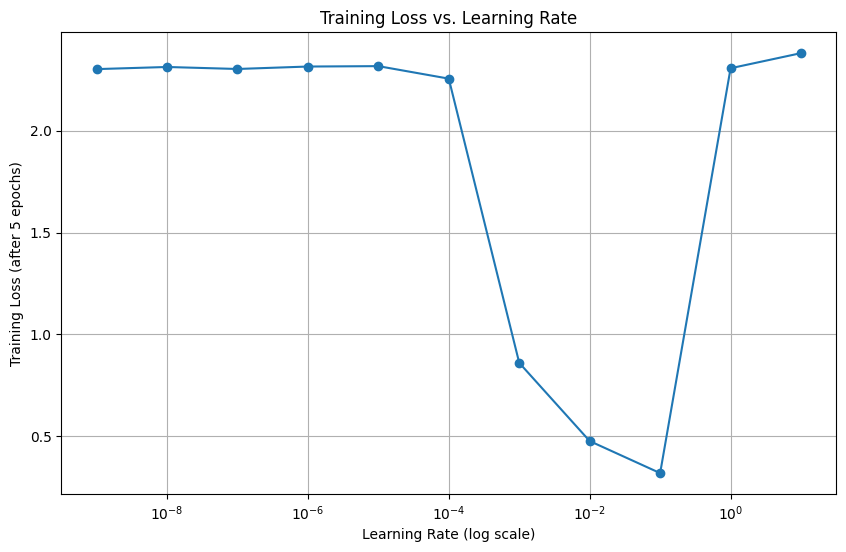

In [4]:
# plotting training loss vs learning rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, losses, marker='o')
plt.xscale('log')
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Training Loss (after 5 epochs)")
plt.title("Training Loss vs. Learning Rate")
plt.grid(True)
plt.show()


### Question 2

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

In [40]:
def build_lenet5():
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), padding='same', input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, kernel_size=(5, 5), padding='valid'))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(84))
    model.add(Activation('relu'))
    model.add(Dense(10, activation='softmax'))

    return model

In [55]:
class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs=None):
        self._set_lr(self.base_lr)

    def on_batch_end(self, batch, logs=None):
        self.trn_iterations += 1
        self.clr_iterations += 1

        lr = self.clr()
        self._set_lr(lr)

        if logs is not None:
            self.history.setdefault('lr', []).append(lr)
            self.history.setdefault('iterations', []).append(self.trn_iterations)
            for k, v in logs.items():
                self.history.setdefault(k, []).append(v)

    def _set_lr(self, lr_value):
        opt = self.model.optimizer


        if hasattr(opt, 'lr') and hasattr(opt.lr, 'assign'):
            opt.lr.assign(lr_value)
        elif hasattr(opt, 'learning_rate') and hasattr(opt.learning_rate, 'assign'):
            opt.learning_rate.assign(lr_value)
        else:
            raise AttributeError("Optimizer has no assignable learning rate.")


In [56]:
lr_min = 1e-4
lr_max = 1e-2
step_size = 2 * (len(x_train) // 64)

In [57]:
clr = CyclicLR(base_lr=lr_min, max_lr=lr_max, step_size=step_size, mode='exp_range', gamma=0.99994)

model = build_lenet5()
optimizer = SGD(learning_rate=lr_min)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
history_cyclic = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[clr],
    verbose=1
)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.1608 - loss: 2.1892 - val_accuracy: 0.6236 - val_loss: 1.0684
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.6820 - loss: 0.8693 - val_accuracy: 0.6940 - val_loss: 0.8427
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.7432 - loss: 0.6826 - val_accuracy: 0.7644 - val_loss: 0.6215
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.7818 - loss: 0.5845 - val_accuracy: 0.7876 - val_loss: 0.5845
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.7958 - loss: 0.5573 - val_accuracy: 0.7817 - val_loss: 0.5889
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.7887 - loss: 0.5658 - val_accuracy: 0.7387 - val_loss: 0.6728
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.8033 - loss: 0.5422 - val_accuracy: 0.8050 - val_loss: 0.5396
Epoch 8/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.8196 - loss: 0.5015 - 

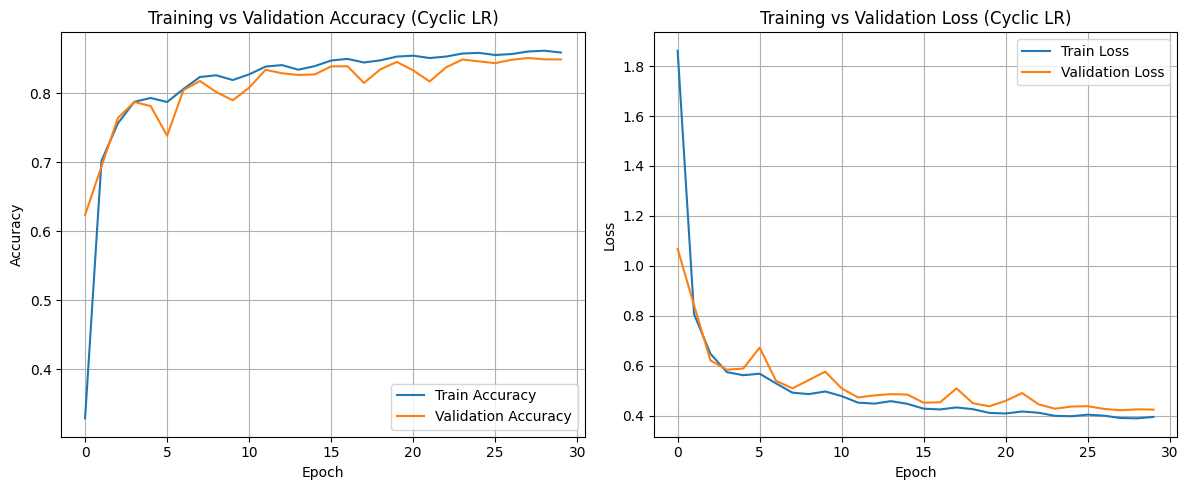

In [59]:
# accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cyclic.history['accuracy'], label='Train Accuracy')
plt.plot(history_cyclic.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy (Cyclic LR)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# loss plot
plt.subplot(1, 2, 2)
plt.plot(history_cyclic.history['loss'], label='Train Loss')
plt.plot(history_cyclic.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss (Cyclic LR)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Question 3

In [63]:
# batch sizes: 32 to 4096 (2^5 to 2^12)
batch_sizes = [2**i for i in range(5, 13)]
lr_fixed = 1e-2  # fixed learning rate from Q1
losses_batch = []

for batch_size in batch_sizes:
    model = build_lenet5()
    model.compile(optimizer=SGD(learning_rate=lr_fixed),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=5,
                        verbose=1)
    losses_batch.append(history.history['loss'][-1])  # final epoch's loss

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.5171 - loss: 1.3907
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.7848 - loss: 0.5855
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.8134 - loss: 0.5067
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.8310 - loss: 0.4602
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.8473 - loss: 0.4220
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.4645 - loss: 1.5512
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.7474 - loss: 0.6755
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.7844 - loss: 0.5808
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.8025 - loss: 0.5306
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8184 - loss: 0.4927
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.3285 - loss: 1.8954
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━

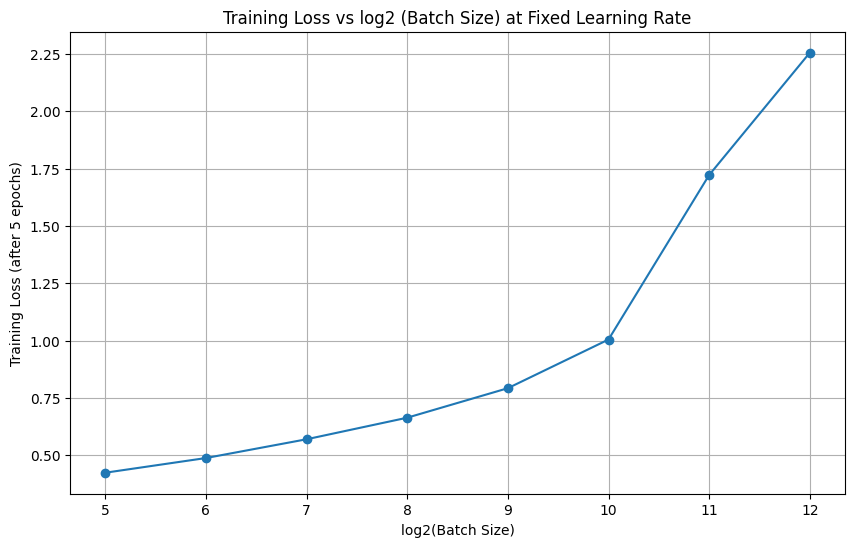

In [65]:
# plot training loss vs. log2(batch size)
plt.figure(figsize=(10, 6))
plt.plot(np.log2(batch_sizes), losses_batch, marker='o')
plt.xlabel('log2(Batch Size)')
plt.ylabel('Training Loss (after 5 epochs)')
plt.title('Training Loss vs log2 (Batch Size) at Fixed Learning Rate')
plt.grid(True)
plt.show()

When comparing the plot above with the plots from part 2, we can see that the generalization of the final model using a fixed learning rate and increasing batch sizes is different from the cyclical learning rate policy.

With the cyclical learning rate, the model achieved consistently lower training and validation loss, along with higher accuracy, suggesting better generalization. In contrast, when increasing batch size at a fixed learning rate, the training loss increased steadily, and the model's ability to generalize diminished.

This indicates that simply increasing batch size does not replicate the benefits of adjusting the learning rate during training. This is because cyclical learning rates help the model train more effectively by allowing it to escape sharp minima and explore flatter regions in the loss landscape, leading to better convergence and generalization.
